 # Feature Extraction
 ## Imports
 General stuff

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft
import os
import pathlib

# Audio processing/tools import
import librosa
import librosa.display
from scipy.io.wavfile import read 
from IPython.display import Audio
# REMEMBER you need ffmpeg installed

# Parellization libraries
from joblib import Parallel, delayed

# Import custom module containing useful functions
import sonicboom

# Import helper functions
import time


 ## Define some constants

In [2]:
SAVEPATH = './output/intermediate-data/'
#FILEDESC = 'filedata-librosaFeatures.pkl'
FILEDESC = 'filedata-mfccDeltaFeaturesforNN.pkl'


 ## Read and add filepaths to original UrbanSound metadata

In [3]:
filedata = sonicboom.init_data('./data/UrbanSound8K/')


Calling 'init_data'
Finished 'init_data' in 0.5466 secs


 ## Sample down

In [4]:
sampleDown = True

# samples down grouping by class - this gives me X items from each class.
# as_index=False is important because otherwise,
# Pandas calls the index and the column the same thing, confusing itself
if (sampleDown == True):
    filedata = filedata.groupby(
        'class', 
        as_index=False, 
        group_keys=False
    ).apply(lambda x: x.sample(n=2, random_state=0))

# check that the sample down is working
# as_index=False is important because otherwise,
# Pandas calls the index and the column the same thing, confusing itself
filedata.groupby('class', as_index=False)['slice_file_name'].nunique()


0    2
1    2
2    2
3    2
4    2
5    2
6    2
7    2
8    2
9    2
Name: slice_file_name, dtype: int64

 ## Read one audio file to see what it contains

Calling 'test_read_audio'
Calling 'load_audio'
Finished 'load_audio' in 2.1523 secs


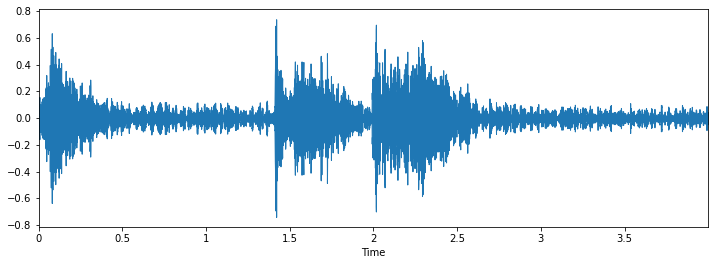

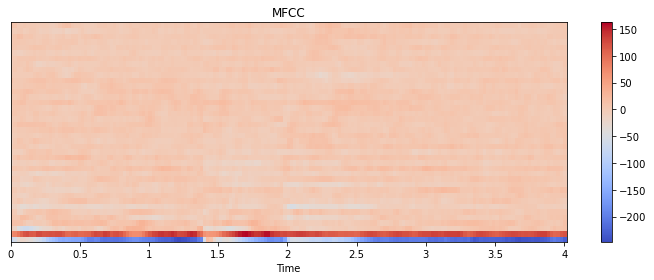

Finished 'test_read_audio' in 3.6529 secs


In [5]:
sonicboom.test_read_audio(filedata.path.iloc[0])


In [6]:
# Get sample rates for all .wave files and add to filedata dataframe

#filedata['Sample Rate'] = Parallel(n_jobs=-1)(delayed(sonicboom.samplerate)(x) for x in filedata['path'])

#filedata.to_csv('./SampleRates.csv')


 ## PARALLEL Generate features and add to dataframe

In [7]:
startTime = time.perf_counter()

#non-parallel version
#filedata['mfccs'] = [sonicboom.mfccsEngineering(x) for x in filedata['path']]

# inputVar = input("0. All, \n \
#     1. MFCCS \n \
#     2. Mel-scaled spectrogram \n \
#     3. Short-time Fourier transform (STFT) \n \
#     4. Chromagram (STFT) \n \
#     5. Spectral contrast (STFT) \n \
#     6. Tonal centroid features (tonnetz) from harmonic components \n")
#     7. Vis's custom FFT feature

mfccs_exec = True
melSpec_exec = False
stft_exec = False #too many elements, array is huge, cannot be flattened
chroma_stft_exec = False 
spectral_contrast_stft_exec = False
tonnetz_exec = False
visFFT_exec = False #huge, cannot be flattened
mfccDelta_exec = True #for neural network only, cannot be normalized
flatten = False
normalize = False

tempDF = pd.DataFrame() 

tempDF = pd.concat(Parallel(n_jobs=-1)(delayed(sonicboom.generateFeatures) \
    (x, mfccs_exec, melSpec_exec, stft_exec, chroma_stft_exec, \
        spectral_contrast_stft_exec, tonnetz_exec, visFFT_exec, mfccDelta_exec, \
        flatten, normalize) for x in filedata['path']))

filedata = filedata.join(tempDF.set_index('path'), on='path')

endTime = time.perf_counter()
runTime = endTime - startTime
print(f'Finished in {runTime:.4f} secs')

filedata.head()


Finished in 17.2046 secs


,path,slice_file_name,fsID,start,end,salience,fold,classID,class,mfccs,mfccDelta
8678,data\UrbanSound8K\audio\fold9\79089-0-0-6.wav,79089-0-0-6.wav,79089,12.664375,16.664375,2,9,0,air_conditioner,"[[-76.58776129942605, -57.577908266483696, -32...","[[[-76.58776129942605, 1.5563431448495995], [-..."
7724,data\UrbanSound8K\audio\fold8\54383-0-0-5.wav,54383-0-0-5.wav,54383,2.500000,6.500000,1,8,0,air_conditioner,"[[-101.46643059629909, -95.77048243734905, -99...","[[[-101.46643059629909, -0.6249407863106456], ..."
3516,data\UrbanSound8K\audio\fold3\9674-1-0-2.wav,9674-1-0-2.wav,9674,2.062597,6.062597,1,3,1,car_horn,"[[-118.11438206828225, -138.31601333849525, -1...","[[[-118.11438206828225, -13.123013075619259], ..."
3913,data\UrbanSound8K\audio\fold4\171249-1-1-0.wav,171249-1-1-0.wav,171249,11.144995,11.723836,2,4,1,car_horn,"[[-304.53067337823586, -297.9546768877072, -29...","[[[-304.53067337823586, 4.56747179182916], [-2..."
8725,data\UrbanSound8K\audio\fold9\99500-2-0-11.wav,99500-2-0-11.wav,99500,5.500000,9.500000,2,9,2,children_playing,"[[-384.04932017853326, -377.8579029732588, -37...","[[[-384.04932017853326, 3.2652485900113177], [..."


 ## Save the generated features

In [8]:
filedata.to_pickle(SAVEPATH + FILEDESC)
